In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [3]:
from matplotlib import pyplot as plt
print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb('/content/drive/MyDrive/Colab Notebooks/Train 60000.cdb')
print('Train Dataset Loaded')
print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb('/content/drive/MyDrive/Colab Notebooks/Test 20000.cdb')
print('Test Dataset Loaded')

Reading Train 60000.cdb ...
Train Dataset Loaded
Reading Test 20000.cdb ...
Test Dataset Loaded


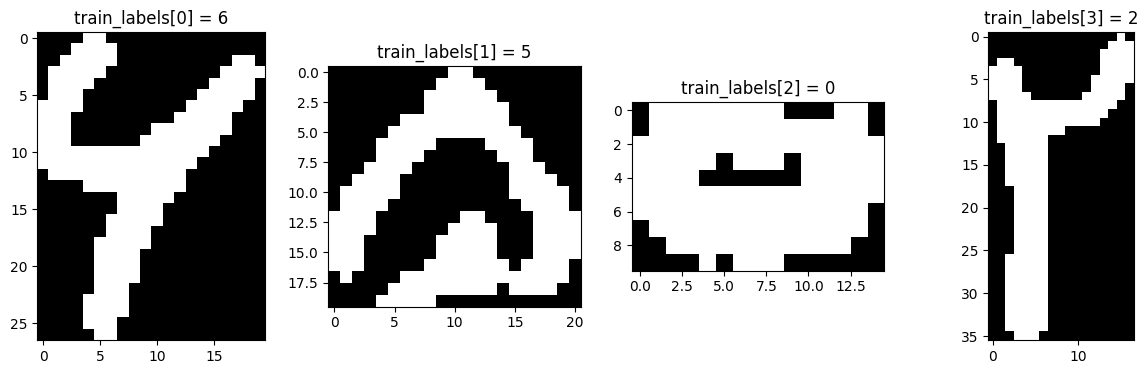

In [4]:
fig = plt.figure(figsize=(15, 4))
for i in range(4):

    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(train_labels[i]))
    plt.imshow(train_images[i], cmap='gray')

plt.show()


In [5]:
import random
train_images_subset = train_images[:3000]
train_labels_subset = train_labels[:3000]
# Select 1000 elements randomly from test_images
selected_indices = random.sample(range(len(test_images)), 1000)
print(selected_indices)
# Use the selected indices to get corresponding images and labels
test_images_subset = [test_images[i] for i in selected_indices]
test_labels_subset = [test_labels[i] for i in selected_indices]


[15442, 12955, 11346, 8364, 18756, 16361, 14467, 15469, 5483, 1055, 3297, 9104, 9175, 2860, 632, 18176, 444, 1657, 18727, 19084, 19793, 5500, 7028, 388, 4578, 15118, 3456, 14988, 16426, 12704, 3475, 19014, 14465, 9677, 6879, 11127, 1237, 10232, 7092, 18409, 14670, 18738, 19737, 5072, 6231, 14478, 7001, 1212, 4421, 16367, 16676, 13656, 7300, 17803, 16557, 1571, 1067, 3492, 10578, 12969, 16019, 15188, 4877, 16126, 12968, 17585, 11265, 6971, 14537, 18770, 2280, 12902, 2085, 3648, 12007, 10210, 8979, 2380, 9630, 17154, 6948, 242, 3735, 11359, 13772, 14849, 12304, 17303, 19709, 8809, 18236, 16115, 9332, 4961, 2718, 2739, 4585, 4748, 6831, 11245, 6662, 17121, 19676, 9195, 1379, 3037, 418, 14043, 7695, 14066, 16679, 12596, 1679, 17719, 6327, 10570, 17058, 13628, 12822, 7166, 19045, 12783, 16256, 11261, 3244, 2029, 12489, 2128, 4906, 14182, 7503, 4749, 9994, 4028, 10932, 12679, 16258, 6972, 1593, 2835, 17710, 3250, 550, 14489, 2667, 4343, 2752, 555, 18267, 6684, 10936, 18706, 19911, 2845, 1052

In [6]:
# Initialize dimensions
max_width, max_width_index = max((img.shape[0], i) for i, img in enumerate(train_images_subset + test_images_subset))
max_length, max_length_index = max((img.shape[1], i) for i, img in enumerate(train_images_subset + test_images_subset))
# Initialize the 3D train matrix
num_images = len(train_images_subset)
matrix_3d_train = np.zeros((num_images, max_width, max_length))
# Initialize the 3D test matrix
num_images1 = len(test_images_subset)
matrix_3d_test = np.zeros((num_images1, max_width, max_length))

In [7]:
# Fill the matrix with image data, centering each image
for i, img in enumerate(train_images_subset):
    start_row = (max_width - img.shape[0]) // 2
    start_col = (max_length - img.shape[1]) // 2
    end_row = start_row + img.shape[0]
    end_col = start_col + img.shape[1]
    matrix_3d_train[i, start_row:end_row, start_col:end_col] = img

# Now, matrix_3d is filled with image data, and each image is centered in its corresponding matrix
for i, img in enumerate(test_images_subset):
    start_row = (max_width - img.shape[0]) // 2
    start_col = (max_length - img.shape[1]) // 2
    end_row = start_row + img.shape[0]
    end_col = start_col + img.shape[1]
    matrix_3d_test[i, start_row:end_row, start_col:end_col] = img

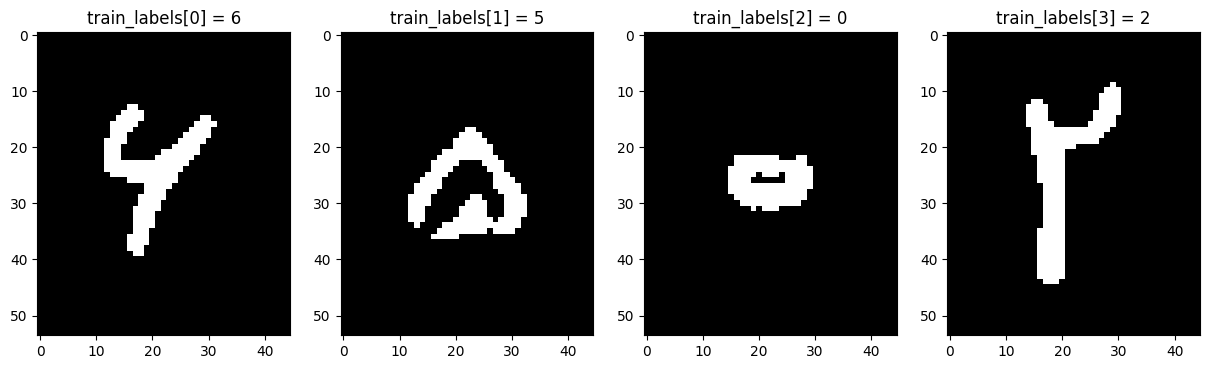

In [8]:
# Plot the first 4 images of matrix_3d
fig = plt.figure(figsize=(15, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(train_labels_subset[i]))
    plt.imshow(matrix_3d_train[i], cmap='gray')

plt.show()

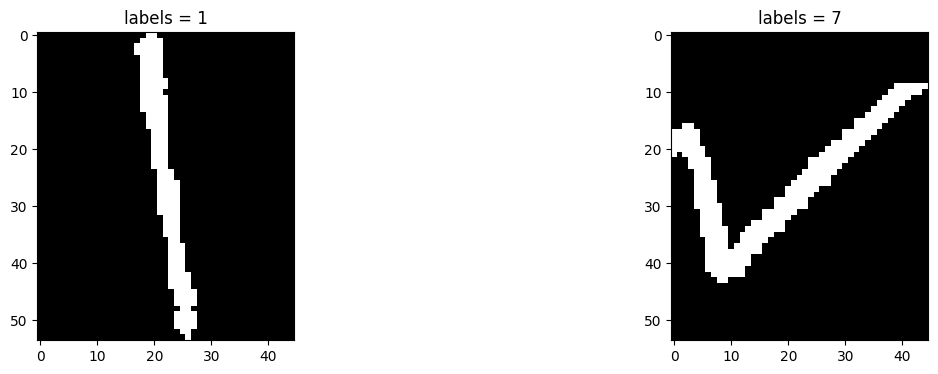

In [9]:
# Plot 2 images of matrix_3d which give us the max_width and max_length
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
plt.title('labels = ' + str((train_labels_subset+test_labels_subset)[max_width_index]))
plt.imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.title('labels = ' + str((train_labels_subset+test_labels_subset)[max_length_index]))
plt.imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_length_index], cmap='gray')

plt.show()

In [10]:
# Calculate horizontal and vertical histograms for all images
horizontal_histograms_train = np.sum(matrix_3d_train, axis=1)
vertical_histograms_train = np.sum(matrix_3d_train, axis=2)
# Now, horizontal_histograms and vertical_histograms contain the histograms for all images
# Each row in these arrays corresponds to an image in train_images_subset
# Calculate horizontal and vertical histograms for all images
horizontal_histograms_test = np.sum(matrix_3d_test, axis=1)
vertical_histograms_test = np.sum(matrix_3d_test, axis=2)
# Now, horizontal_histograms and vertical_histograms contain the histograms for all images
# Each row in these arrays corresponds to an image in train_images_subset

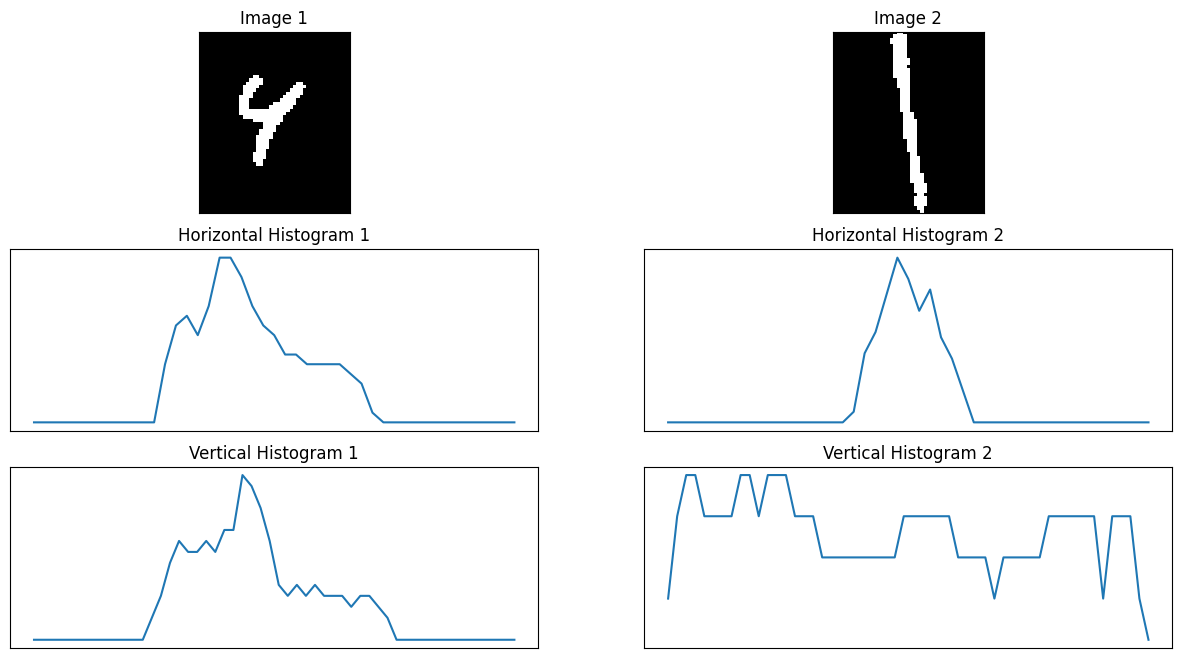

In [11]:
# Plot the horizontal and vertical histograms along with 2 images

fig, axes = plt.subplots(3, 2, figsize=(15, 8))

# Plot the first image
axes[0, 0].imshow(matrix_3d_train[0], cmap='gray')
axes[0, 0].set_title('Image 1')
axes[0, 0].set_xticks([])  # Hide x-axis ticks
axes[0, 0].set_yticks([])  # Hide y-axis ticks

# Plot the horizontal histogram for the first image
axes[1, 0].plot(horizontal_histograms_train[0])
axes[1, 0].set_title('Horizontal Histogram 1')
axes[1, 0].set_xticks([])  # Hide x-axis ticks
axes[1, 0].set_yticks([])  # Hide y-axis ticks

# Plot the vertical histogram for the first image
axes[2, 0].plot(vertical_histograms_train[0])
axes[2, 0].set_title('Vertical Histogram 1')
axes[2, 0].set_xticks([])  # Hide x-axis ticks
axes[2, 0].set_yticks([])  # Hide y-axis ticks

# Plot the second image
axes[0, 1].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
axes[0, 1].set_title('Image 2')
axes[0, 1].set_xticks([])  # Hide x-axis ticks
axes[0, 1].set_yticks([])  # Hide y-axis ticks

# Plot the horizontal histogram for the second image
axes[1, 1].plot(np.concatenate((horizontal_histograms_train, horizontal_histograms_test), axis=0)[max_width_index])
axes[1, 1].set_title('Horizontal Histogram 2')
axes[1, 1].set_xticks([])  # Hide x-axis ticks
axes[1, 1].set_yticks([])  # Hide y-axis ticks

# Plot the vertical histogram for the second image
axes[2, 1].plot(np.concatenate((vertical_histograms_train, vertical_histograms_test), axis=0)[max_width_index])
axes[2, 1].set_title('Vertical Histogram 2')
axes[2, 1].set_xticks([])  # Hide x-axis ticks
axes[2, 1].set_yticks([])  # Hide y-axis ticks

plt.show()

In [12]:
def zoning(matrix):
# Initialize dimensions
    num_images, max_width, max_length = matrix.shape

# Calculate zoning feature vectors for all images
    zoning_feature_vectors = []

# Iterate over images
    for img_idx in range(num_images):
        zoning_feature_vector = []

    # Iterate over zones (5x5)
        for i in range(5):
            for j in range(5):
            # Calculate average intensity in the current zone for the current image
                avg_intensity = np.mean(matrix[img_idx,
                                                        i * max_width // 5 : (i + 1) * max_width // 5,
                                                        j * max_length // 5 : (j + 1) * max_length // 5])
                zoning_feature_vector.append(avg_intensity)

        zoning_feature_vectors.append(zoning_feature_vector)
    return zoning_feature_vectors
# Now, zoning_feature_vectors is a list containing the zoning feature vector for each image in matrix
# Each element of the list corresponds to an image
zoning_feature_vectors_train = zoning(matrix_3d_train)
zoning_feature_vectors_test = zoning(matrix_3d_test)
# Reshape zoning feature vectors to 5x5 matrices
zoning_matrices_train = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning(matrix_3d_train)]
zoning_matrices_test = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning(matrix_3d_test)]


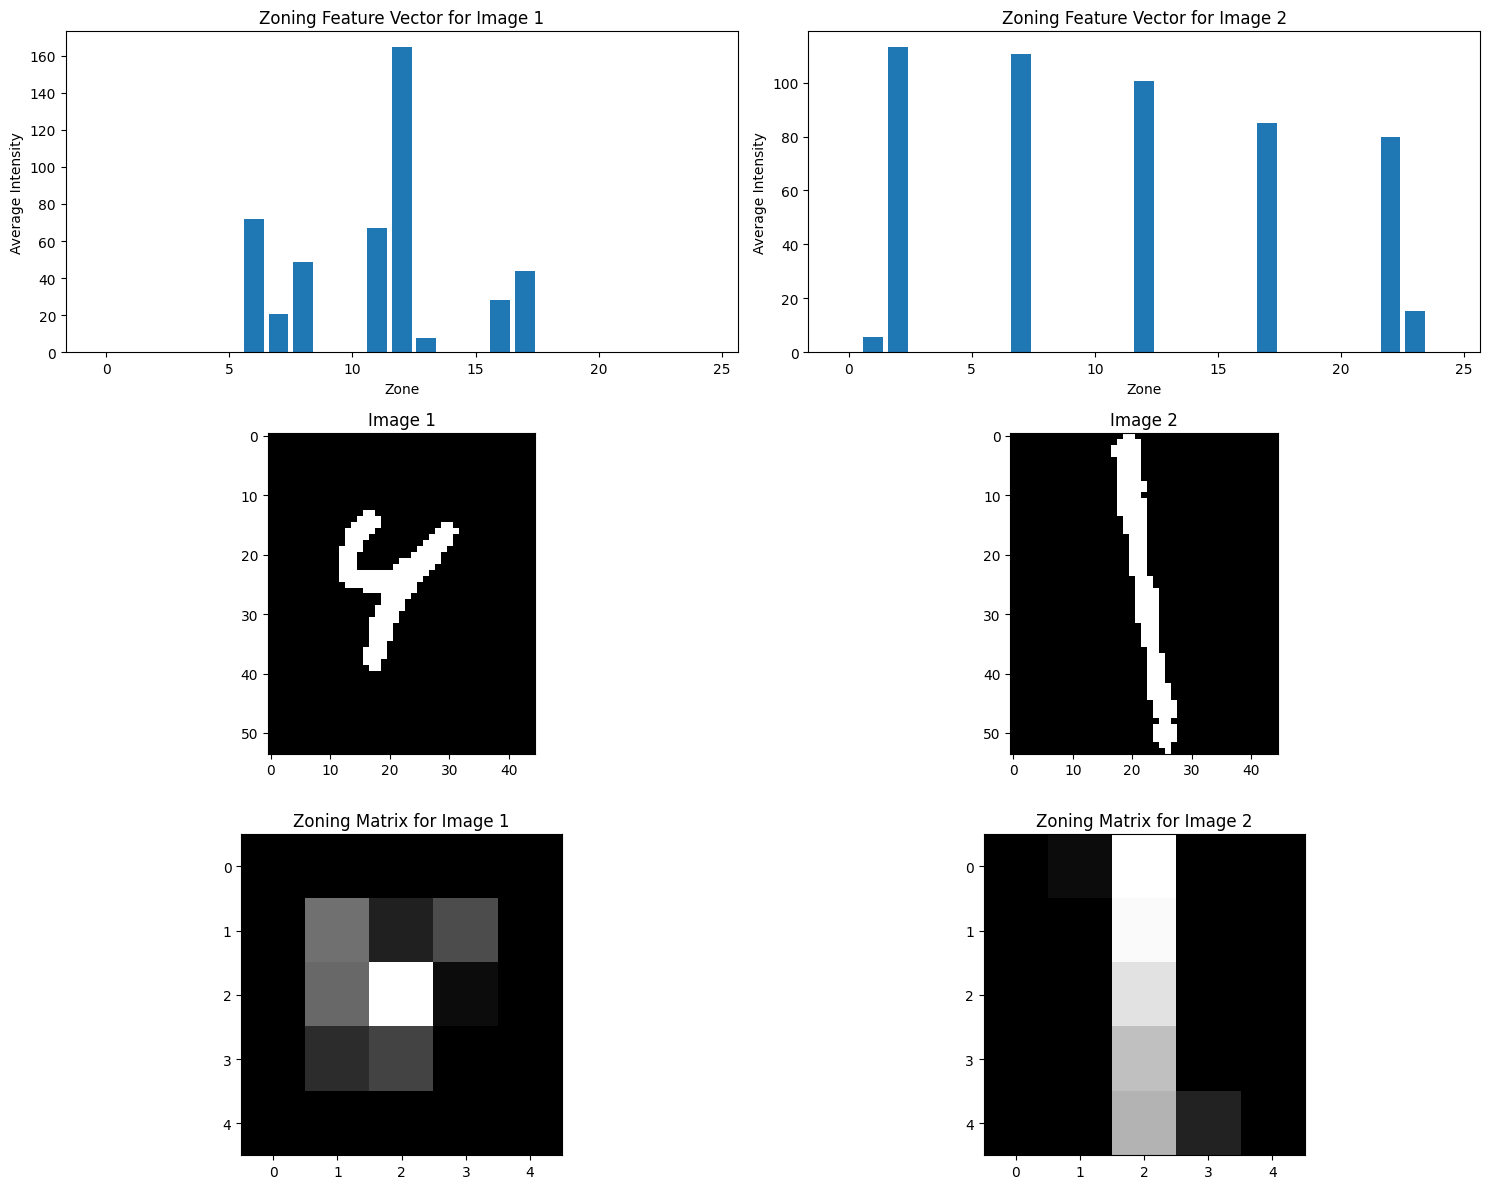

In [13]:

# Plot zoning feature vectors along with the images for the first two images
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot zoning feature vector for the first image
axes[0, 0].bar(range(len(zoning_feature_vectors_train[0])), zoning_feature_vectors_train[0])
axes[0, 0].set_title('Zoning Feature Vector for Image 1')
axes[0, 0].set_xlabel('Zone')
axes[0, 0].set_ylabel('Average Intensity')

# Plot zoning feature vector for the second image
axes[0, 1].bar(range(len((zoning_feature_vectors_train+zoning_feature_vectors_test)[max_width_index])), (zoning_feature_vectors_train+zoning_feature_vectors_test)[max_width_index])
axes[0, 1].set_title('Zoning Feature Vector for Image 2')
axes[0, 1].set_xlabel('Zone')
axes[0, 1].set_ylabel('Average Intensity')

# Plot the first image
axes[1, 0].imshow(matrix_3d_train[0], cmap='gray')
axes[1, 0].set_title('Image 1')

# Plot the second image
axes[1, 1].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
axes[1, 1].set_title('Image 2')

# Plot zoning matrix for the first image
axes[2, 0].imshow(zoning_matrices_train[0], cmap='gray')
axes[2, 0].set_title('Zoning Matrix for Image 1')
# Plot zoning matrix for the second image
axes[2, 1].imshow((zoning_matrices_train+zoning_matrices_test)[max_width_index], cmap='gray')
axes[2, 1].set_title('Zoning Matrix for Image 2')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
import pywt
from skimage.transform import resize
# Function to resize each image to 64x64
def resize_images(images):
    resized_images = np.zeros((images.shape[0], 64, 64))
    for i in range(images.shape[0]):
        resized_images[i] = resize(images[i], (64, 64), mode='constant', anti_aliasing=True)
    return resized_images

# Function to extract wavelet features
def extract_wavelet_features(image):
    coeffs = pywt.wavedec2(image, 'haar', level=3)
    # Select the approximation coefficients at level 3 (8x8 image)
    features = coeffs[0].ravel()
    return features

# Resize the images
resized_images_train = resize_images(matrix_3d_train)

# Extract wavelet features for each image
wavelet_features_train = np.array([extract_wavelet_features(img) for img in resized_images_train])
# wavelet_features now contains the desired features for each image
# Its shape should be (3000, 64)
# Resize the images
resized_images_test = resize_images(matrix_3d_test)

# Extract wavelet features for each image
wavelet_features_test = np.array([extract_wavelet_features(img) for img in resized_images_test])

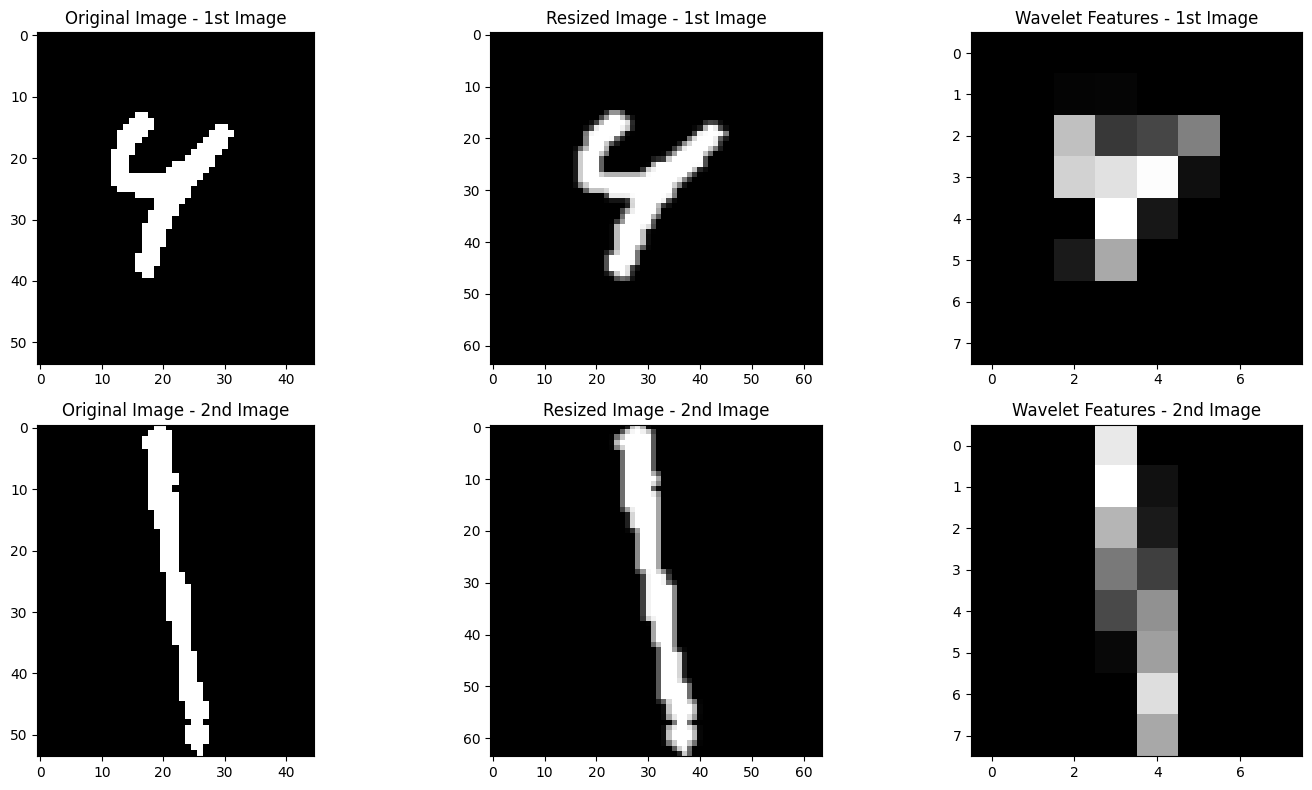

In [15]:
# Plot original images and wavelet features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# Reshape the wavelet features back to 8x8 images
reshaped_wavelet_features_1st = wavelet_features_train[0].reshape((8, 8))
reshaped_wavelet_features_2nd = np.concatenate((wavelet_features_train, wavelet_features_test), axis=0)[max_width_index].reshape((8, 8))
# Plot original images
axes[0, 0].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[0], cmap='gray')
axes[0, 0].set_title('Original Image - 1st Image')

axes[1, 0].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
axes[1, 0].set_title('Original Image - 2nd Image')

# Plot wavelet features for the first image
axes[0, 1].imshow(resized_images_train[0], cmap='gray')
axes[0, 1].set_title('Resized Image - 1st Image')

axes[0, 2].imshow(reshaped_wavelet_features_1st, cmap='gray', interpolation='nearest')
axes[0, 2].set_title('Wavelet Features - 1st Image')

# Plot wavelet features for the second image
axes[1, 1].imshow(np.concatenate((resized_images_train, resized_images_test), axis=0)[max_width_index], cmap='gray')
axes[1, 1].set_title('Resized Image - 2nd Image')

axes[1, 2].imshow(reshaped_wavelet_features_2nd, cmap='gray', interpolation='nearest')
axes[1, 2].set_title('Wavelet Features - 2nd Image')

plt.tight_layout()
plt.show()

In [16]:
#Check correctness of dimension of train and test features
print(horizontal_histograms_train.shape)
print(vertical_histograms_train.shape)
print(horizontal_histograms_test.shape)
print(vertical_histograms_test.shape)
print(np.array(zoning_feature_vectors_train).shape)
print(np.array(zoning_feature_vectors_test).shape)
print(wavelet_features_train.shape)
print(wavelet_features_test.shape)
#normalize data
from sklearn.preprocessing import MinMaxScaler
# Assuming you have imported the necessary libraries and have your data loaded in the variables mentioned

# Normalizing ndarrays
scaler = MinMaxScaler()

horizontal_histograms_train = scaler.fit_transform(horizontal_histograms_train)
vertical_histograms_train = scaler.fit_transform(vertical_histograms_train)

horizontal_histograms_test  = scaler.fit_transform(horizontal_histograms_test)
vertical_histograms_test = scaler.fit_transform(vertical_histograms_test)

wavelet_features_train = scaler.fit_transform(wavelet_features_train)
wavelet_features_test = scaler.fit_transform(wavelet_features_test)

# Normalizing lists
zoning_feature_vectors_train = [scaler.fit_transform(np.array(vec).reshape(-1, 1)) for vec in zoning_feature_vectors_train]
zoning_feature_vectors_test = [scaler.fit_transform(np.array(vec).reshape(-1, 1)) for vec in zoning_feature_vectors_test]

(3000, 45)
(3000, 54)
(1000, 45)
(1000, 54)
(3000, 25)
(1000, 25)
(3000, 64)
(1000, 64)


Best number of clusters (k) based on silhouette score: 4
[[ 0.13093889  0.38302832 -0.08057119]
 [-0.49919354 -0.02335952  0.1344013 ]
 [ 0.0346075  -0.20741082 -0.22451335]
 [ 0.57900361 -0.1855653   0.30275822]]
(4, 3)


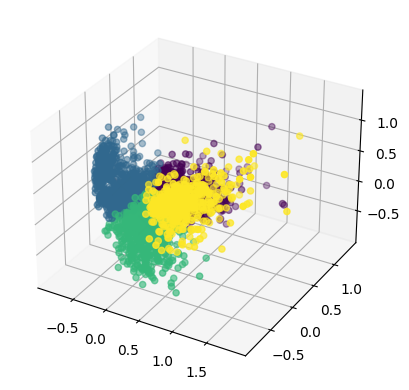

In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Assuming you have horizontal_histograms_train and it contains your training data
# Assuming you have horizontal_histograms_test and it contains your test data

# Apply PCA
pca = PCA(n_components=3) # Number of principal components you want to retain
horizontal_histograms_pca = pca.fit_transform(horizontal_histograms_train)
horizontal_histograms_pca_test = pca.transform(horizontal_histograms_test)

# Define different values of k for KMeans
k_values = [4, 6, 8, 10, 12]  # Example values, you can change this

# Calculate silhouette scores for different k values
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    kmeans.fit(horizontal_histograms_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(horizontal_histograms_pca, labels))

# Find the best k based on silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print("Best number of clusters (k) based on silhouette score:", best_k)

# Apply PCA
pca = PCA(n_components=3)  # Number of principal components you want to retain
horizontal_histograms_pca = pca.fit_transform(horizontal_histograms_train)
horizontal_histograms_pca_test = pca.transform(horizontal_histograms_test)

# Apply KMeans clustering on the reduced dimensional data
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100)  # You can change the number of clusters as per your requirement
kmeans.fit(horizontal_histograms_pca)  # Fit KMeans to the PCA-transformed training data

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

print(cluster_centers)
print(cluster_centers.shape)

# Assuming cluster_centers is the variable containing the cluster centers

# Plotting the data points and cluster centers in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(horizontal_histograms_pca[:, 0], horizontal_histograms_pca[:, 1], horizontal_histograms_pca[:, 2], c=kmeans.labels_)

# Plot the cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200)

plt.show()

In [18]:
from sklearn.preprocessing import OneHotEncoder
tls = np.array(train_labels_subset).reshape(-1,1)
encoder = OneHotEncoder(sparse= False)
Y = encoder.fit_transform(tls)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return x * (1.0 - x)

# Fill hidden and output layers with random values.
w_hidden = cluster_centers
w_output = np.round(np.random.uniform(-10, 10, size=(10, 4)), 1)
# Print  weights
print("Hidden Weights:")
print(w_hidden)

print("\ninitial Output Weights:")
print(w_output)
# Lists to store errors, hidden weights, and output weights for each epoch
errors = []
hidden_weights_history = []
output_weights_history = []
learning_rate = 0.02
# Learning iteration
for epoch in range(3):
  for _ in range(3000):
    # Define the input vector
    input_vector = horizontal_histograms_pca[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    output = np.dot(actual_hidden.T, w_output.T)

    # Calculate error (expected output - calculated output)
    error = Y[_, :].T - output
    errors.append(np.mean(np.abs(error)))  # Save the mean absolute error for each epoch

    # Backward Propagation
    dZ = error * learning_rate
    #print(w_output.shape)
    #print(error.shape)
    #print(actual_hidden.shape)
    #print(dZ.shape)
    #print(output.shape)
    w_output += np.dot(actual_hidden.reshape(4,1), dZ.reshape(10,1).T).T
    output_weights_history.append(np.copy(w_output))


# Print final weights
print("Hidden Weights:")
print(w_hidden)

print("\nfinal Output Weights:")
print(w_output)

Hidden Weights:
[[ 0.13093889  0.38302832 -0.08057119]
 [-0.49919354 -0.02335952  0.1344013 ]
 [ 0.0346075  -0.20741082 -0.22451335]
 [ 0.57900361 -0.1855653   0.30275822]]

initial Output Weights:
[[  2.6 -10.    2.8   0.2]
 [ -6.5   5.7  -1.4  -3.8]
 [ -4.3  -7.6  -5.8   9. ]
 [  8.5  -3.4   3.3   4.5]
 [ -1.3   0.7  -9.5  -9.3]
 [ -3.6   1.1  -5.9   6.2]
 [  7.1  -1.3  -9.6   9.1]
 [  5.7   9.9  -1.6   5.6]
 [  0.4   4.2   6.7  -1.4]
 [ -4.1   2.2  -3.1  -8.9]]
Hidden Weights:
[[ 0.13093889  0.38302832 -0.08057119]
 [-0.49919354 -0.02335952  0.1344013 ]
 [ 0.0346075  -0.20741082 -0.22451335]
 [ 0.57900361 -0.1855653   0.30275822]]

final Output Weights:
[[-0.26015057  0.38161708  0.47927367 -0.48118659]
 [-0.40027226  0.97631572 -0.5133193   0.23298162]
 [ 0.20715694  0.44980193 -0.58954388  0.1318634 ]
 [ 0.68096906 -0.11078473 -0.36299384  0.02680949]
 [ 0.86320204 -0.01304363 -0.59058446 -0.03888373]
 [-0.35700066  0.17616497 -0.53300136  1.26543564]
 [ 0.67742135  0.30850527 -0.

In [21]:
outputs = np.zeros((1000,10))
for _ in range(1000):
    # Define the input vector
    input_vector = horizontal_histograms_pca_test[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    outputs[_, :] = np.dot(actual_hidden.T, w_output.T)

In [25]:
pred = np.argmax(outputs, axis = 1)
print(pred)
print(np.array(train_labels_subset))
print(np.sum(pred==np.array(test_labels_subset)))
print("Accuracy by Horizontal Histogram:   " + str(np.sum(pred==np.array(test_labels_subset))/1000*100))

[1 9 0 4 0 9 9 0 1 0 1 1 9 1 1 9 1 1 5 9 5 0 6 0 1 9 9 0 4 9 1 5 1 4 0 4 0
 5 6 5 5 9 9 1 3 0 6 1 1 9 9 9 5 9 5 1 1 1 5 4 0 5 1 5 5 4 5 4 9 6 1 5 1 1
 1 9 6 1 1 9 5 1 1 5 6 5 0 9 5 4 9 4 5 4 1 1 4 1 5 5 0 9 5 5 0 1 0 5 4 5 0
 0 1 9 1 9 5 9 9 5 9 0 9 5 1 9 6 1 5 9 1 0 0 4 5 1 4 5 9 1 5 1 0 5 1 9 0 9
 9 5 5 9 4 1 0 0 5 9 9 3 4 0 9 4 4 5 5 5 6 1 5 0 5 5 6 4 4 1 6 9 9 9 9 1 5
 9 4 1 9 1 9 9 1 1 5 1 1 1 0 1 9 5 5 9 9 1 1 1 5 1 1 1 9 9 1 4 4 1 4 1 5 4
 9 5 1 9 9 1 1 5 1 5 1 9 9 9 5 5 4 5 5 4 1 1 4 1 9 9 5 0 1 4 5 1 3 9 1 5 5
 5 5 9 9 5 5 4 9 1 4 6 4 1 5 0 4 0 5 4 9 5 5 5 1 5 4 1 1 5 4 4 5 9 9 6 5 1
 4 4 0 9 9 9 6 4 1 0 1 1 5 4 1 5 1 4 5 1 5 9 1 5 9 4 9 9 3 4 0 4 4 4 0 1 5
 9 1 0 1 9 1 4 0 4 9 9 6 5 0 5 4 4 0 1 4 0 0 6 0 9 5 5 5 4 5 9 4 1 9 1 5 0
 0 4 5 5 1 0 9 9 4 5 1 9 9 4 0 5 5 9 1 9 4 1 0 1 1 5 4 9 5 9 1 0 9 5 4 9 9
 4 1 4 1 5 9 0 1 1 1 4 5 1 5 4 4 3 9 1 4 0 1 1 5 4 1 1 1 0 4 4 0 9 1 4 0 6
 9 9 0 1 4 5 5 5 1 5 1 9 5 1 9 0 5 9 4 4 5 1 1 5 1 5 1 5 3 1 1 9 4 1 5 0 6
 1 5 4 0 5 0 4 5 4 6 9 4 

Best number of clusters (k) based on silhouette score: 4
[[ 0.78344865 -0.31673699  0.12231993]
 [ 0.11609822 -0.12480715 -0.15212337]
 [ 0.11117606  0.59998745  0.10252565]
 [-0.49088291 -0.08493118  0.04827979]]
(4, 3)


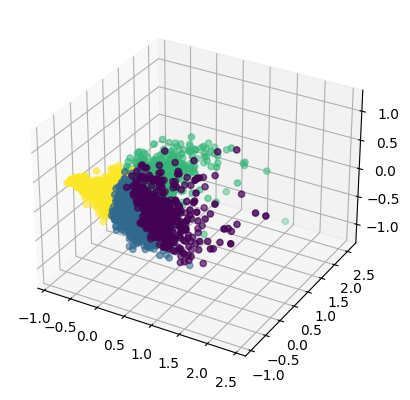

Hidden Weights:
[[ 0.78344865 -0.31673699  0.12231993]
 [ 0.11609822 -0.12480715 -0.15212337]
 [ 0.11117606  0.59998745  0.10252565]
 [-0.49088291 -0.08493118  0.04827979]]

initial Output Weights:
[[  5.3 -10.   -5.1  -2.1]
 [ -5.6  -9.5  -2.    0. ]
 [  4.    3.6   5.5  -7.4]
 [  8.5  -4.1  -1.9   4.1]
 [  1.5   1.8   2.3   4.8]
 [ -9.6  -0.5  -1.7  -3.5]
 [ -6.7   2.8   1.1   1.5]
 [  5.2   7.   -0.8   2.7]
 [  7.3  -2.4   1.9   0.2]
 [  5.6   5.    6.5   6.7]]
Hidden Weights:
[[ 0.78344865 -0.31673699  0.12231993]
 [ 0.11609822 -0.12480715 -0.15212337]
 [ 0.11117606  0.59998745  0.10252565]
 [-0.49088291 -0.08493118  0.04827979]]

final Output Weights:
[[ 1.24454192 -1.90117525 -0.11547261  1.46616498]
 [ 0.59175448 -0.9018711  -0.19356182  0.95501664]
 [-0.21544155  0.77781178 -0.30923671 -0.31643732]
 [ 1.57587022 -1.21650328 -0.17755751  0.51741212]
 [ 0.31367361  0.08761296 -0.1018856  -0.04662148]
 [-0.84542917  0.43596827  1.16449506 -0.60197423]
 [-0.63466138  1.29464289 -0.

In [26]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# Apply PCA
pca = PCA(n_components=3) # Number of principal components you want to retain
vertical_histograms_pca = pca.fit_transform(vertical_histograms_train)
vertical_histograms_pca_test = pca.transform(vertical_histograms_test)

# Define different values of k for KMeans
k_values = [4, 6, 8, 10, 12]  # Example values, you can change this

# Calculate silhouette scores for different k values
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    kmeans.fit(vertical_histograms_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(vertical_histograms_pca, labels))

# Find the best k based on silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print("Best number of clusters (k) based on silhouette score:", best_k)

# Apply PCA
pca = PCA(n_components=3)  # Number of principal components you want to retain
vertical_histograms_pca = pca.fit_transform(vertical_histograms_train)
vertical_histograms_pca_test = pca.transform(vertical_histograms_test)

# Apply KMeans clustering on the reduced dimensional data
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100)  # You can change the number of clusters as per your requirement
kmeans.fit(vertical_histograms_pca)  # Fit KMeans to the PCA-transformed training data

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

print(cluster_centers)
print(cluster_centers.shape)

# Assuming cluster_centers is the variable containing the cluster centers

# Plotting the data points and cluster centers in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(vertical_histograms_pca[:, 0], vertical_histograms_pca[:, 1], vertical_histograms_pca[:, 2], c=kmeans.labels_)

# Plot the cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200)

plt.show()


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return x * (1.0 - x)

# Fill hidden and output layers with random values.
w_hidden = cluster_centers
w_output = np.round(np.random.uniform(-10, 10, size=(10, 4)), 1)
# Print  weights
print("Hidden Weights:")
print(w_hidden)

print("\ninitial Output Weights:")
print(w_output)
# Lists to store errors, hidden weights, and output weights for each epoch
errors = []
hidden_weights_history = []
output_weights_history = []
learning_rate = 0.02
# Learning iteration
for epoch in range(3):
  for _ in range(3000):
    # Define the input vector
    input_vector = vertical_histograms_pca[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    output = np.dot(actual_hidden.T, w_output.T)

    # Calculate error (expected output - calculated output)
    error = Y[_, :].T - output
    errors.append(np.mean(np.abs(error)))  # Save the mean absolute error for each epoch

    # Backward Propagation
    dZ = error * learning_rate
    #print(w_output.shape)
    #print(error.shape)
    #print(actual_hidden.shape)
    #print(dZ.shape)
    #print(output.shape)
    w_output += np.dot(actual_hidden.reshape(4,1), dZ.reshape(10,1).T).T
    output_weights_history.append(np.copy(w_output))


# Print final weights
print("Hidden Weights:")
print(w_hidden)

print("\nfinal Output Weights:")
print(w_output)

outputs = np.zeros((1000,10))
for _ in range(1000):
    # Define the input vector
    input_vector = vertical_histograms_pca_test[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    outputs[_, :] = np.dot(actual_hidden.T, w_output.T)


pred = np.argmax(outputs, axis = 1)
print(pred)
print(np.array(train_labels_subset))
print(np.sum(pred==np.array(test_labels_subset)))
print("Accuracy by Vertical Histogram:   " + str(np.sum(pred==np.array(test_labels_subset))/1000*100))

Best number of clusters (k) based on silhouette score: 4
[[-0.53762431 -0.18337885 -0.01601502]
 [ 0.59631106 -0.31247447  0.00165042]
 [-0.04602074  0.38124581  0.42246969]
 [ 0.14537905  0.45954645 -0.38316692]]
(4, 3)


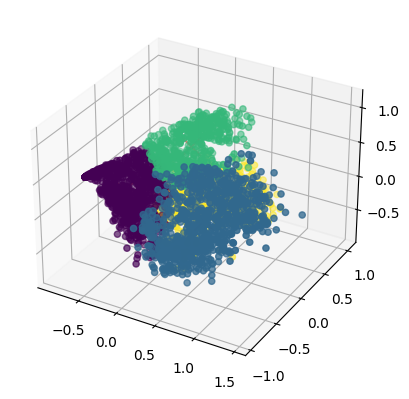

Hidden Weights:
[[-0.53762431 -0.18337885 -0.01601502]
 [ 0.59631106 -0.31247447  0.00165042]
 [-0.04602074  0.38124581  0.42246969]
 [ 0.14537905  0.45954645 -0.38316692]]

initial Output Weights:
[[ 2.5  3.7 -4.3 -3. ]
 [-2.8  4.8 -7.1  8.6]
 [ 7.8  7.7  5.9  3.5]
 [-6.9  0.9  5.6 -7.7]
 [ 8.4 -4.7  6.9 -0.5]
 [-1.1 -1.8 -1.6 -3.2]
 [ 0.5  0.7  4.5  7. ]
 [-7.9 -2.2  6.4  8.7]
 [ 3.7 -0.8  7.5  2.3]
 [-1.2 -1.5  9.2 -5.6]]
Hidden Weights:
[[-0.53762431 -0.18337885 -0.01601502]
 [ 0.59631106 -0.31247447  0.00165042]
 [-0.04602074  0.38124581  0.42246969]
 [ 0.14537905  0.45954645 -0.38316692]]

final Output Weights:
[[ 0.60471384  0.05239401 -0.04862402 -0.43586202]
 [ 0.89673531 -0.19975845 -0.8963824   0.40075771]
 [ 0.09297598 -0.30616585 -0.11257883  0.49418101]
 [-0.39003049 -0.19055216  0.34667538  0.52853994]
 [-0.24251359  0.06143808  0.20776484  0.26925282]
 [-0.22463574  0.81753278  0.144957   -0.43065875]
 [ 0.08740067 -0.24259867  0.25103631  0.19156333]
 [-0.47673104 -0.3

In [33]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
zoning_feature_vectors_train = np.array(zoning_feature_vectors_train).reshape(3000, 25)
zoning_feature_vectors_test = np.array(zoning_feature_vectors_test).reshape(1000, 25)
# Apply PCA
pca = PCA(n_components=3) # Number of principal components you want to retain
zoning_pca = pca.fit_transform(zoning_feature_vectors_train)
zoning_pca_test = pca.transform(zoning_feature_vectors_test)

# Define different values of k for KMeans
k_values = [4, 6, 8, 10, 12]  # Example values, you can change this

# Calculate silhouette scores for different k values
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    kmeans.fit(zoning_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(zoning_pca, labels))

# Find the best k based on silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print("Best number of clusters (k) based on silhouette score:", best_k)

# Apply PCA
pca = PCA(n_components=3)  # Number of principal components you want to retain
zoning_pca = pca.fit_transform(zoning_feature_vectors_train)
zoning_pca_test = pca.transform(zoning_feature_vectors_test)

# Apply KMeans clustering on the reduced dimensional data
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100)  # You can change the number of clusters as per your requirement
kmeans.fit(zoning_pca)  # Fit KMeans to the PCA-transformed training data

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

print(cluster_centers)
print(cluster_centers.shape)

# Assuming cluster_centers is the variable containing the cluster centers

# Plotting the data points and cluster centers in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(zoning_pca[:, 0], zoning_pca[:, 1], zoning_pca[:, 2], c=kmeans.labels_)

# Plot the cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200)

plt.show()


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return x * (1.0 - x)

# Fill hidden and output layers with random values.
w_hidden = cluster_centers
w_output = np.round(np.random.uniform(-10, 10, size=(10, 4)), 1)
# Print  weights
print("Hidden Weights:")
print(w_hidden)

print("\ninitial Output Weights:")
print(w_output)
# Lists to store errors, hidden weights, and output weights for each epoch
errors = []
hidden_weights_history = []
output_weights_history = []
learning_rate = 0.02
# Learning iteration
for epoch in range(3):
  for _ in range(3000):
    # Define the input vector
    input_vector = zoning_pca[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    output = np.dot(actual_hidden.T, w_output.T)

    # Calculate error (expected output - calculated output)
    error = Y[_, :].T - output
    errors.append(np.mean(np.abs(error)))  # Save the mean absolute error for each epoch

    # Backward Propagation
    dZ = error * learning_rate
    #print(w_output.shape)
    #print(error.shape)
    #print(actual_hidden.shape)
    #print(dZ.shape)
    #print(output.shape)
    w_output += np.dot(actual_hidden.reshape(4,1), dZ.reshape(10,1).T).T
    output_weights_history.append(np.copy(w_output))


# Print final weights
print("Hidden Weights:")
print(w_hidden)

print("\nfinal Output Weights:")
print(w_output)

outputs = np.zeros((1000,10))
for _ in range(1000):
    # Define the input vector
    input_vector = zoning_pca_test[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    outputs[_, :] = np.dot(actual_hidden.T, w_output.T)


pred = np.argmax(outputs, axis = 1)
print(pred)
print(np.array(train_labels_subset))
print(np.sum(pred==np.array(test_labels_subset)))
print("Accuracy by Zoning Feature:   " + str(np.sum(pred==np.array(test_labels_subset))/1000*100))

Best number of clusters (k) based on silhouette score: 4
[[ 0.44077583 -0.45697611  0.02460177]
 [ 0.19644021  0.52909589 -0.30759143]
 [ 0.02140248  0.42421976  0.4830368 ]
 [-0.5155016  -0.15679651 -0.04073868]]
(4, 3)


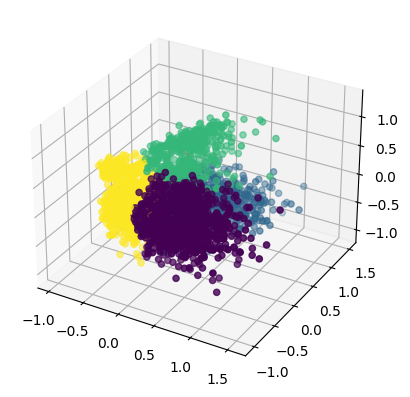

Hidden Weights:
[[ 0.44077583 -0.45697611  0.02460177]
 [ 0.19644021  0.52909589 -0.30759143]
 [ 0.02140248  0.42421976  0.4830368 ]
 [-0.5155016  -0.15679651 -0.04073868]]

initial Output Weights:
[[ 7.1  4.5 -5.1  9.5]
 [ 1.   7.3 -3.  -1.6]
 [ 9.9  3.7  2.7 -3.1]
 [ 2.3  9.6  9.2 -6.9]
 [-3.   0.9 -2.3 10. ]
 [-3.7  3.7 -0.2  3. ]
 [ 4.6 -5.4 -2.5 -1.1]
 [-8.2  7.4 -7.3 -1. ]
 [-9.  -6.  -6.  -8.8]
 [-1.  -4.3  1.  -2.8]]
Hidden Weights:
[[ 0.44077583 -0.45697611  0.02460177]
 [ 0.19644021  0.52909589 -0.30759143]
 [ 0.02140248  0.42421976  0.4830368 ]
 [-0.5155016  -0.15679651 -0.04073868]]

final Output Weights:
[[-0.23787557  0.01705379 -0.29230568  0.6777263 ]
 [-0.21029731  0.26667551 -0.8000957   0.9111534 ]
 [-0.22317353  0.64452891 -0.41989991  0.14410305]
 [-0.12557765  0.7035326  -0.02620204 -0.26206151]
 [-0.01460398  0.75028411 -0.28187141 -0.16795069]
 [ 0.80877154 -0.15023431 -0.10335482 -0.24615751]
 [-0.14524604  0.13872415  0.3818697  -0.05556039]
 [-0.27958156 -0.0

In [37]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=3) # Number of principal components you want to retain
wavelet_pca = pca.fit_transform(wavelet_features_train)
wavelet_pca_test = pca.transform(wavelet_features_test)

# Define different values of k for KMeans
k_values = [4, 6, 8, 10, 12]  # Example values, you can change this

# Calculate silhouette scores for different k values
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    kmeans.fit(wavelet_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(wavelet_pca, labels))

# Find the best k based on silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print("Best number of clusters (k) based on silhouette score:", best_k)

# Apply PCA
pca = PCA(n_components=3)  # Number of principal components you want to retain
wavelet_pca = pca.fit_transform(wavelet_features_train)
wavelet_pca_test = pca.transform(wavelet_features_test)

# Apply KMeans clustering on the reduced dimensional data
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100)  # You can change the number of clusters as per your requirement
kmeans.fit(wavelet_pca)  # Fit KMeans to the PCA-transformed training data

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

print(cluster_centers)
print(cluster_centers.shape)

# Assuming cluster_centers is the variable containing the cluster centers

# Plotting the data points and cluster centers in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(wavelet_pca[:, 0], wavelet_pca[:, 1], wavelet_pca[:, 2], c=kmeans.labels_)

# Plot the cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200)

plt.show()


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return x * (1.0 - x)

# Fill hidden and output layers with random values.
w_hidden = cluster_centers
w_output = np.round(np.random.uniform(-10, 10, size=(10, 4)), 1)
# Print  weights
print("Hidden Weights:")
print(w_hidden)

print("\ninitial Output Weights:")
print(w_output)
# Lists to store errors, hidden weights, and output weights for each epoch
errors = []
hidden_weights_history = []
output_weights_history = []
learning_rate = 0.02
# Learning iteration
for epoch in range(3):
  for _ in range(3000):
    # Define the input vector
    input_vector = wavelet_pca[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    output = np.dot(actual_hidden.T, w_output.T)

    # Calculate error (expected output - calculated output)
    error = Y[_, :].T - output
    errors.append(np.mean(np.abs(error)))  # Save the mean absolute error for each epoch

    # Backward Propagation
    dZ = error * learning_rate
    #print(w_output.shape)
    #print(error.shape)
    #print(actual_hidden.shape)
    #print(dZ.shape)
    #print(output.shape)
    w_output += np.dot(actual_hidden.reshape(4,1), dZ.reshape(10,1).T).T
    output_weights_history.append(np.copy(w_output))


# Print final weights
print("Hidden Weights:")
print(w_hidden)

print("\nfinal Output Weights:")
print(w_output)

outputs = np.zeros((1000,10))
for _ in range(1000):
    # Define the input vector
    input_vector = wavelet_pca_test[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    outputs[_, :] = np.dot(actual_hidden.T, w_output.T)


pred = np.argmax(outputs, axis = 1)
print(pred)
print(np.array(train_labels_subset))
print(np.sum(pred==np.array(test_labels_subset)))
print("Accuracy by Wavelet Feature:   " + str(np.sum(pred==np.array(test_labels_subset))/1000*100))

0.1
0.2
0.3
0.4
0.5
Best bandwidth for Mean Shift: 0.5
[[-0.59010036 -0.15488741  0.04772756]
 [ 0.24782327 -0.48350758 -0.01550698]
 [-0.13400484  0.33766672 -0.11024577]]
(3, 3)


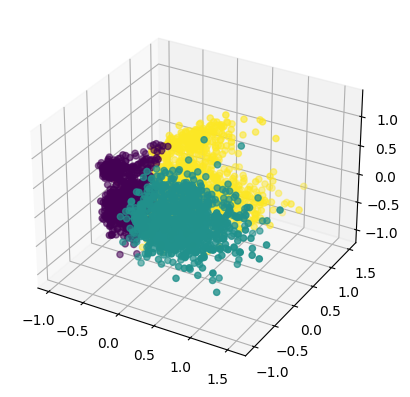

In [42]:

import numpy as np
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=3)
wavelet_pca = pca.fit_transform(wavelet_features_train)
wavelet_pca_test = pca.transform(wavelet_features_test)

# Optimize bandwidth for Mean Shift
bandwidth_values = [0.1,0.2, 0.3,0.4, 0.5]  # Example values, you can change this

silhouette_scores = []
for bandwidth in bandwidth_values:
    print(bandwidth)
    mean_shift = MeanShift(bandwidth=bandwidth)
    labels = mean_shift.fit_predict(wavelet_pca)
    silhouette_scores.append(silhouette_score(wavelet_pca, labels))

# Find the best bandwidth based on silhouette score
best_bandwidth = bandwidth_values[np.argmax(silhouette_scores)]
print("Best bandwidth for Mean Shift:", best_bandwidth)

# Apply Mean Shift clustering on the reduced dimensional data
mean_shift = MeanShift(bandwidth=best_bandwidth)
labels = mean_shift.fit_predict(wavelet_pca)

# Get the cluster centers
cluster_centers = mean_shift.cluster_centers_

print(cluster_centers)
print(cluster_centers.shape)

# Plotting the data points and cluster centers in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(wavelet_pca[:, 0], wavelet_pca[:, 1], wavelet_pca[:, 2], c=labels)

# Plot the cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200)

plt.show()



In [43]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return x * (1.0 - x)

# Fill hidden and output layers with random values.
w_hidden = cluster_centers
w_output = np.round(np.random.uniform(-10, 10, size=(10, 3)), 1)
# Print  weights
print("Hidden Weights:")
print(w_hidden)

print("\ninitial Output Weights:")
print(w_output)
# Lists to store errors, hidden weights, and output weights for each epoch
errors = []
hidden_weights_history = []
output_weights_history = []
learning_rate = 0.02
# Learning iteration
for epoch in range(3):
  for _ in range(3000):
    # Define the input vector
    input_vector = wavelet_pca[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    output = np.dot(actual_hidden.T, w_output.T)

    # Calculate error (expected output - calculated output)
    error = Y[_, :].T - output
    errors.append(np.mean(np.abs(error)))  # Save the mean absolute error for each epoch

    # Backward Propagation
    dZ = error * learning_rate
    #print(w_output.shape)
    #print(error.shape)
    #print(actual_hidden.shape)
    #print(dZ.shape)
    #print(output.shape)
    w_output += np.dot(actual_hidden.reshape(3,1), dZ.reshape(10,1).T).T
    output_weights_history.append(np.copy(w_output))


# Print final weights
print("Hidden Weights:")
print(w_hidden)

print("\nfinal Output Weights:")
print(w_output)

outputs = np.zeros((1000,10))
for _ in range(1000):
    # Define the input vector
    input_vector = wavelet_pca_test[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    outputs[_, :] = np.dot(actual_hidden.T, w_output.T)


pred = np.argmax(outputs, axis = 1)
print(pred)
print(np.array(train_labels_subset))
print(np.sum(pred==np.array(test_labels_subset)))
print("Accuracy by Wavelet Feature:   " + str(np.sum(pred==np.array(test_labels_subset))/1000*100))

Hidden Weights:
[[-0.59010036 -0.15488741  0.04772756]
 [ 0.24782327 -0.48350758 -0.01550698]
 [-0.13400484  0.33766672 -0.11024577]]

initial Output Weights:
[[ 9.1 -9.6 -7.7]
 [ 8.8  5.7 -5.1]
 [ 6.2  7.8  3.4]
 [-0.7 -0.8 -8.4]
 [ 8.2  4.6  0.9]
 [-3.4 -2.1  0.6]
 [ 0.1 -4.9 -7.6]
 [-7.6  6.  -3.6]
 [-7.3 -6.9 -8.3]
 [ 4.3  0.8  0.7]]
Hidden Weights:
[[-0.59010036 -0.15488741  0.04772756]
 [ 0.24782327 -0.48350758 -0.01550698]
 [-0.13400484  0.33766672 -0.11024577]]

final Output Weights:
[[ 1.17155246 -0.28802712 -0.65153548]
 [ 1.03169113 -0.1782442  -0.58661066]
 [-0.07904163 -0.23101014  0.43972759]
 [-0.26262989 -0.05767853  0.4924253 ]
 [-0.2918785   0.02030758  0.47954487]
 [-0.2682092   0.73460165 -0.16963822]
 [-0.10537471 -0.12435384  0.47803444]
 [-0.09611075 -0.13286329  0.34141926]
 [-0.06712468  0.63173952 -0.41407052]
 [-0.04501291  0.62327373 -0.30368415]]
[0 5 0 6 5 5 6 0 6 0 0 6 6 0 0 5 0 0 5 1 5 0 6 0 6 6 1 0 1 5 0 5 6 6 6 5 0
 5 6 6 6 1 5 1 4 0 6 0 0 5 9 5 4 5 5 

0.1
0.2
0.3
0.4
0.5
Best bandwidth for Mean Shift: 0.4
[[-0.56986531 -0.07966154 -0.19040031]
 [-0.69507804 -0.30424295  0.18080122]
 [-0.40986839  0.18654386  0.11233639]
 [ 0.55459181 -0.45717181 -0.15581831]
 [-0.16970246  0.48559764  0.38753995]
 [ 0.65666855 -0.20606907  0.27343981]
 [ 0.47617402  0.46551057 -0.31334653]
 [-0.07080023  0.50585838 -0.47159757]
 [ 0.08394271  0.02300196  0.20272232]
 [ 0.48281406  0.10480551  0.03218229]
 [-0.07396241 -0.32175222 -0.40037402]]
(11, 3)


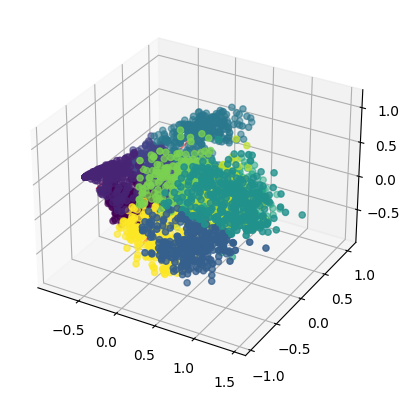

Hidden Weights:
[[-0.56986531 -0.07966154 -0.19040031]
 [-0.69507804 -0.30424295  0.18080122]
 [-0.40986839  0.18654386  0.11233639]
 [ 0.55459181 -0.45717181 -0.15581831]
 [-0.16970246  0.48559764  0.38753995]
 [ 0.65666855 -0.20606907  0.27343981]
 [ 0.47617402  0.46551057 -0.31334653]
 [-0.07080023  0.50585838 -0.47159757]
 [ 0.08394271  0.02300196  0.20272232]
 [ 0.48281406  0.10480551  0.03218229]
 [-0.07396241 -0.32175222 -0.40037402]]

initial Output Weights:
[[-3.5  5.1 -2.5  1.6  9.  -2.6 -3.2 -7.9  2.5 -8.3  9.2]
 [-0.5  2.5  8.2  0.8  7.9  4.4  8.7 -6.4  8.5  0.1 -1.5]
 [ 8.6  9.8  2.4 -8.3  3.4  1.4 -1.8  2.1 -7.8 -0.7  4.6]
 [-7.4 -5.5  2.1  0.2 -9.5  1.4 -9.2  5.7 -3.7  3.4 -7.5]
 [-6.   5.9 -3.6 -7.8 -9.9  3.   9.6  2.1  4.2  6.1  8.8]
 [-9.7 -1.5 -7.4  3.  -3.1  6.8  7.3  7.6 -9.6 -6.8  5.7]
 [-3.6 -4.2 -2.5  8.9  6.3 -0.3 -6.1  9.8 -9.3  4.5  1.3]
 [ 5.2 -7.1  2.8 -8.  -8.2 -3.2 -2.1  9.1  0.7  5.6  6.8]
 [ 8.8  4.   2.2 -5.7 -0.1  0.7 -3.   5.7  9.4  8.2 -7.9]
 [ 3.  

In [47]:

import numpy as np
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

zoning_feature_vectors_train = np.array(zoning_feature_vectors_train).reshape(3000, 25)
zoning_feature_vectors_test = np.array(zoning_feature_vectors_test).reshape(1000, 25)
# Apply PCA
pca = PCA(n_components=3) # Number of principal components you want to retain
zoning_pca = pca.fit_transform(zoning_feature_vectors_train)
zoning_pca_test = pca.transform(zoning_feature_vectors_test)

# Optimize bandwidth for Mean Shift
bandwidth_values = [0.1,0.2, 0.3,0.4, 0.5]  # Example values, you can change this

silhouette_scores = []
for bandwidth in bandwidth_values:
    print(bandwidth)
    mean_shift = MeanShift(bandwidth=bandwidth)
    labels = mean_shift.fit_predict(zoning_pca)
    silhouette_scores.append(silhouette_score(zoning_pca, labels))

# Find the best bandwidth based on silhouette score
best_bandwidth = bandwidth_values[np.argmax(silhouette_scores)]
print("Best bandwidth for Mean Shift:", best_bandwidth)

# Apply Mean Shift clustering on the reduced dimensional data
mean_shift = MeanShift(bandwidth=best_bandwidth)
labels = mean_shift.fit_predict(zoning_pca)

# Get the cluster centers
cluster_centers = mean_shift.cluster_centers_

print(cluster_centers)
print(cluster_centers.shape)

# Plotting the data points and cluster centers in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(zoning_pca[:, 0], zoning_pca[:, 1], zoning_pca[:, 2], c=labels)

# Plot the cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200)

plt.show()

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return x * (1.0 - x)

# Fill hidden and output layers with random values.
w_hidden = cluster_centers
w_output = np.round(np.random.uniform(-10, 10, size=(10, 11)), 1)
# Print  weights
print("Hidden Weights:")
print(w_hidden)

print("\ninitial Output Weights:")
print(w_output)
# Lists to store errors, hidden weights, and output weights for each epoch
errors = []
hidden_weights_history = []
output_weights_history = []
learning_rate = 0.02
# Learning iteration
for epoch in range(3):
  for _ in range(3000):
    # Define the input vector
    input_vector = zoning_pca[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    output = np.dot(actual_hidden.T, w_output.T)

    # Calculate error (expected output - calculated output)
    error = Y[_, :].T - output
    errors.append(np.mean(np.abs(error)))  # Save the mean absolute error for each epoch

    # Backward Propagation
    dZ = error * learning_rate
    #print(w_output.shape)
    #print(error.shape)
    #print(actual_hidden.shape)
    #print(dZ.shape)
    #print(output.shape)
    w_output += np.dot(actual_hidden.reshape(11,1), dZ.reshape(10,1).T).T
    output_weights_history.append(np.copy(w_output))


# Print final weights
print("Hidden Weights:")
print(w_hidden)

print("\nfinal Output Weights:")
print(w_output)

outputs = np.zeros((1000,10))
for _ in range(1000):
    # Define the input vector
    input_vector = zoning_pca_test[ _ , :]

    # Calculate the 2-norm of the difference between the input vector and each weight vector
    norms = np.linalg.norm(input_vector - w_hidden, axis=1)

    # Calculate e^(-A) where A is the 2-norm of the difference
    actual_hidden = np.exp(-norms)
    outputs[_, :] = np.dot(actual_hidden.T, w_output.T)


pred = np.argmax(outputs, axis = 1)
print(pred)
print(np.array(train_labels_subset))
print(np.sum(pred==np.array(test_labels_subset)))
print("Accuracy by Zoning Feature:   " + str(np.sum(pred==np.array(test_labels_subset))/1000*100))